In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Liberaries

In [15]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [16]:
import os
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as gpd
import ee
import wxee
import geemap
import rioxarray
import rasterio
import pickle
import geopandas as gpd
import pyproj

sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *
from qdwb.coordinate.extract import *

In [6]:
ee.Authenticate()
wxee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=i8GHW0wzn6W1aCAw0w7WwVkU5bU-gvtcJC1UP0TgJa0&tc=jCMeqvpX2puuiMqjN8hD4L2fUe3Q8l8GkUaKb9fXMf4&cc=vrRnhtHXKke3jK4MFgZORR2L2InnB7HS_7pkfbc-VF4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VPxQAk8b2beInkzX9k5wKPBQVhRIHAzLPUZPMp9Wz1FcjRhvMR_940

Successfully saved authorization token.


# Varables

In [17]:
PATH_DATA = "/content/drive/MyDrive/WaterBalance_new/assets/"

# mashhad
LAT_MIN = 35.80
LAT_MAX = 37.11
LON_MIN = 58.31
LON_MAX = 60.14

# USA
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40


# Functions

In [18]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

# Load Data

In [19]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "nc/P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)
 
# mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file(PATH_DATA + "shape/usa.shp")
mashhad = gpd.read_file(PATH_DATA + "shape/mahdoode_mashhad.shp")


In [20]:


# Map = geemap.Map()
# Map.add_basemap('HYBRID')


shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])


# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
CN_Wyoming =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')


CN_Wyoming = CN_Wyoming.clip(shape)
 
# Map.centerObject(shape, 9)
# Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
# Map

In [21]:
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray(scale=250, crs='EPSG:3857')
arr

Downloading:   0%|          | 0.00/76.1k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 728, x: 816)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 4.455e+06 4.455e+06 4.454e+06 ... 4.273e+06 4.273e+06
  * x        (x) float64 6.491e+06 6.491e+06 6.492e+06 ... 6.695e+06 6.695e+06
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... 64.0 64.0 64.0 64.0
Attributes:
    transform:               (250.0, 0.0, 6491000.0, 0.0, -250.0, 4455000.0)
    crs:                     +init=epsg:3857
    res:                     (250.0, 250.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## reroject CN array accoring to precipitation array

In [32]:
data = P
# Define the source and target CRS
source_crs = pyproj.CRS('EPSG:4326')
target_crs = pyproj.CRS('EPSG:3857')

# Create a coordinate transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Reproject the data to the target CRS
data = data.rename({'lon': 'x','lat': 'y'})
data = data.rio.write_crs("epsg:4326", inplace=True)
reprojected_data = data.rio.reproject(target_crs, transformer=transformer)
reprojected_data

<xarray.Dataset>
Dimensions:        (x: 17, y: 15, time: 1)
Coordinates:
  * x              (x) float64 6.496e+06 6.508e+06 ... 6.678e+06 6.69e+06
  * y              (y) float64 4.447e+06 4.435e+06 ... 4.289e+06 4.277e+06
  * time           (time) datetime64[ns] 2022-01-31
    spatial_ref    int64 0
Data variables:
    precipitation  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [33]:

da = arr.rio.write_crs("epsg:3857", inplace=True)

# P = P.rio.write_crs("epsg:3857", inplace=True)

# p = P.rename({'lon': 'x','lat': 'y'})

xds_repr_match = da.rio.reproject_match(reprojected_data, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match


<xarray.Dataset>
Dimensions:      (x: 17, y: 15, time: 1)
Coordinates:
  * x            (x) float64 6.496e+06 6.508e+06 6.52e+06 ... 6.678e+06 6.69e+06
  * y            (y) float64 4.447e+06 4.435e+06 ... 4.289e+06 4.277e+06
  * time         (time) datetime64[ns] 2015-01-01
    spatial_ref  int64 0
Data variables:
    dry          (time, y, x) float64 80.0 75.0 57.0 75.0 ... 80.0 59.0 59.0
Attributes:
    transform:               (250.0, 0.0, 6491000.0, 0.0, -250.0, 4455000.0)
    res:                     (250.0, 250.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

## plot reprojected CN array

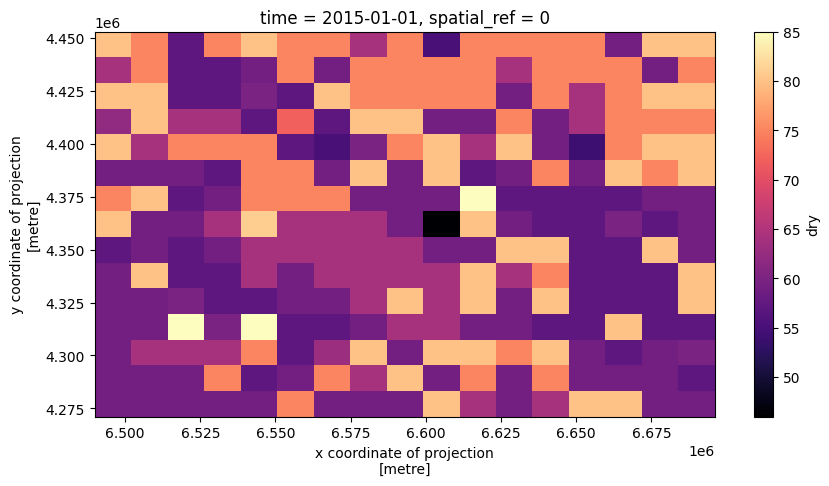

In [34]:
xds_repr_match.dry.plot(figsize=(10, 5), cmap="magma")

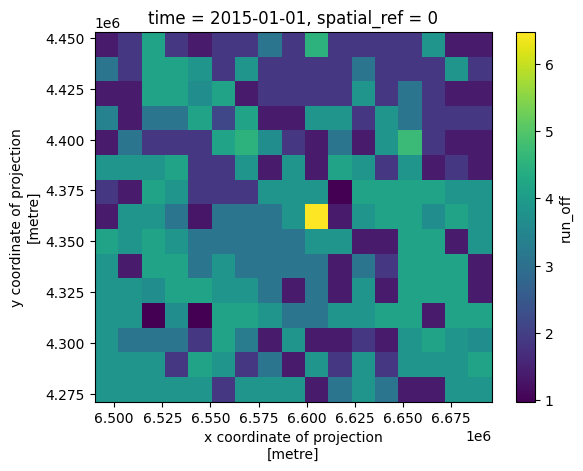

In [35]:
cn =list(xds_repr_match.dry.values.flatten())
pre =list(reprojected_data.precipitation.values.flatten())

run_off = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[0]
for i, j in zip(pre,cn)])

underground_runoff = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[1]
for i, j in zip(pre,cn)])

run_off_array = run_off.reshape(1,15,17)
underground_runoff_array = underground_runoff.reshape(1,15,17)


ds_array = xds_repr_match.assign(run_off=(['time', 'y', 'x'], run_off_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_1.run_off.plot()


In [36]:
# Map = geemap.Map()
# Map.add_basemap('HYBRID')

soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('ssm').mean().clip(shape)

sub_soilmoisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2022-01-31T00:00:00', '2022-02-01T00:00:00')).select('susm').mean().clip(shape)
# Map.centerObject(shape, 9)
# Map.addLayer(soilmoisture, {'min':0, 'max':28, 'palette': ['0300ff', '418504', 'efff07', 'efff07', 'ff0303']}, 'soilmoisture')
# Map

In [37]:
soil_era_evap = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2022-01-31', '2022-02-01')).select('volumetric_soil_water_layer_1').mean().clip(shape)

In [38]:
soilmoisture = soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
sub_soilmoisture = sub_soilmoisture.set("system:time_start", ee.Date("2022-01-31"))
soil_era_evap_1 = soil_era_evap.set("system:time_start", ee.Date("2022-01-31"))

arr_soilmoisture = soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:3857')
arr_sub_soilmoisture = sub_soilmoisture.wx.to_xarray(scale=10000, crs='EPSG:3857')
arr_soil_era_evap_1 = soil_era_evap_1.wx.to_xarray(scale=11132, crs='EPSG:3857')
arr_soil_era_evap_1

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/1.76k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:                        (time: 1, y: 18, x: 19)
Coordinates:
  * time                           (time) datetime64[ns] 2022-01-31
  * y                              (y) float64 4.458e+06 4.447e+06 ... 4.269e+06
  * x                              (x) float64 6.496e+06 6.507e+06 ... 6.696e+06
Data variables:
    volumetric_soil_water_layer_1  (time, y, x) float64 0.3136 0.3211 ... 0.1295
Attributes:
    transform:               (11132.0, 0.0, 6489956.0, 0.0, -11132.0, 4463932.0)
    crs:                     +init=epsg:3857
    res:                     (11132.0, 11132.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [47]:
da_soilmoisture = arr_soilmoisture.rio.write_crs("epsg:3857", inplace=True)
da_sub_soilmoisture = arr_sub_soilmoisture.rio.write_crs("epsg:3857", inplace=True)
da_soil_era_evap_1 = arr_soil_era_evap_1.rio.write_crs("epsg:3857", inplace=True)

xds_repr_match__soilmoisture = da_soilmoisture.rio.reproject_match(reprojected_data, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__sub_soilmoisture = da_sub_soilmoisture.rio.reproject_match(reprojected_data, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match__soil_era_evap_1 = da_soil_era_evap_1.rio.reproject_match(reprojected_data, resampling = rasterio.enums.Resampling.nearest)


xds_repr_match__soil_era_evap_1 = xds_repr_match__soil_era_evap_1 * 70
xds_repr_match__soil_era_evap_1

<xarray.Dataset>
Dimensions:                        (x: 17, y: 15, time: 1)
Coordinates:
  * x                              (x) float64 6.496e+06 6.508e+06 ... 6.69e+06
  * y                              (y) float64 4.447e+06 4.435e+06 ... 4.277e+06
  * time                           (time) datetime64[ns] 2022-01-31
    spatial_ref                    int64 0
Data variables:
    volumetric_soil_water_layer_1  (time, y, x) float64 21.95 22.47 ... 8.413
Attributes:
    transform:               (11132.0, 0.0, 6489956.0, 0.0, -11132.0, 4463932.0)
    res:                     (11132.0, 11132.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

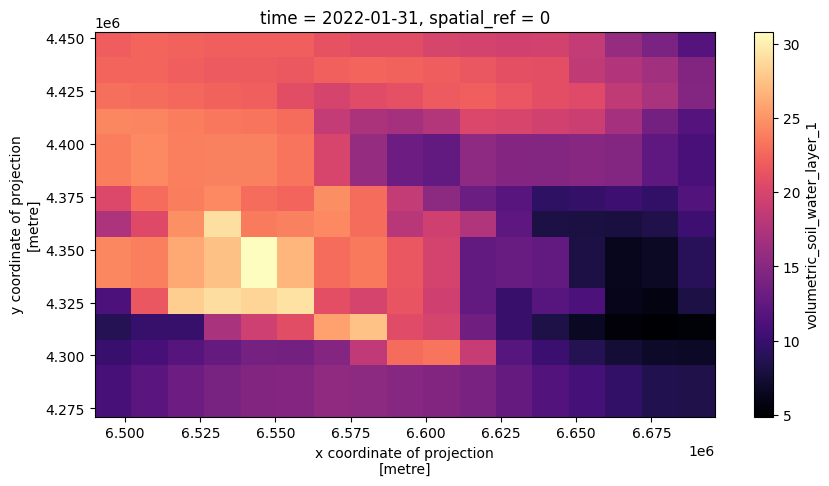

In [40]:
xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.plot(figsize=(10, 5), cmap="magma")

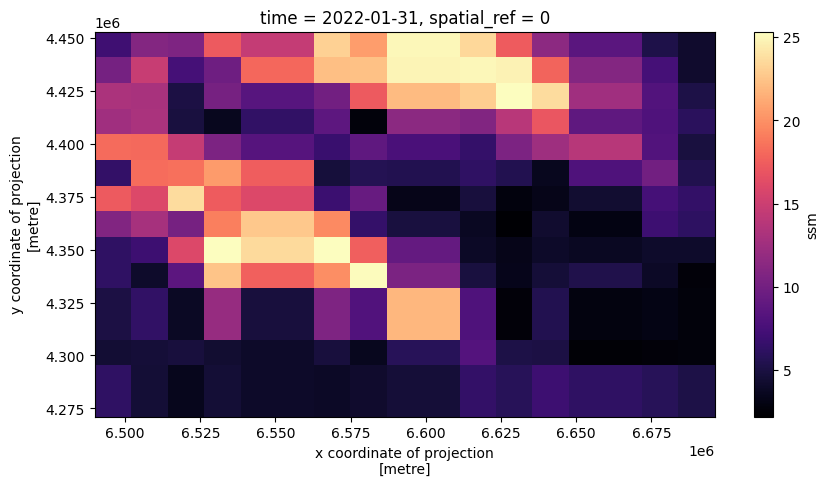

In [41]:
xds_repr_match__soilmoisture.ssm.plot(figsize=(10, 5), cmap="magma")

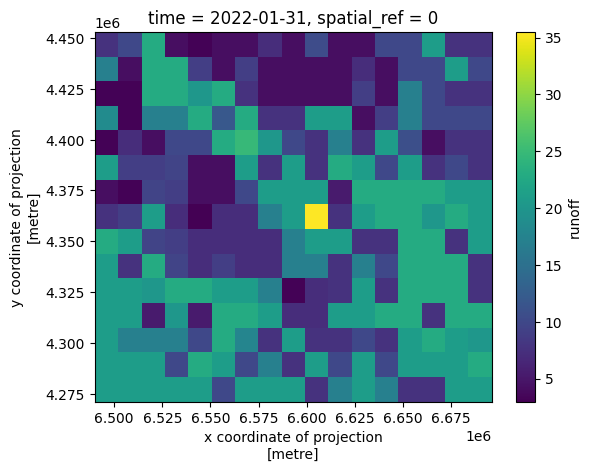

In [42]:
cn = list(xds_repr_match.dry.values.flatten())
pre = list(reprojected_data.precipitation.values.flatten())
soil = list(xds_repr_match__soilmoisture.ssm.values.flatten())
sub_soil = list(xds_repr_match__sub_soilmoisture.susm.values.flatten())
soil_era = list(xds_repr_match__soil_era_evap_1.volumetric_soil_water_layer_1.values.flatten())

runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[0]
for i, j, z in zip(pre, cn, soil)])

underground_runoff_array = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = float(j),
    rsa = True,
    antecedent_precipitation = float(z),
    is_growing_season = True
)[1]
for i, j, z in zip(pre, cn, soil)])

soil_array = np.array(soil)
sub_soil_array = np.array(sub_soil)
soil_era_array = np.array(soil_era)

runoff_array = runoff_array.reshape(1,15,17)
underground_runoff_array = underground_runoff_array.reshape(1,15,17)
soil_array = soil_array.reshape(1,15,17)
sub_soil_array = sub_soil_array.reshape(1,15,17)
soil_era_array = soil_era_array.reshape(1,15,17)


ds_array = reprojected_data.assign(runoff=(['time', 'y', 'x'], runoff_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'y', 'x'], underground_runoff_array))
ds_array_2 = ds_array_1.assign(soilmoisture=(['time', 'y', 'x'], soil_array))
ds_array_3 = ds_array_2.assign(sub_soilmoisture=(['time', 'y', 'x'], sub_soil_array))
ds_array_3_1 = ds_array_3.assign(soil_era=(['time', 'y', 'x'], soil_era_array))


ds_array_3_1.runoff.plot()



In [43]:
df = ds_array_3_1.to_dataframe()

with pd.ExcelWriter('/content/drive/MyDrive/WaterBalance_new/assets/output_nasa.xlsx') as writer:
    df.to_excel(writer)

In [44]:
df_1 = xds_repr_match.to_dataframe()
with pd.ExcelWriter('/content/drive/MyDrive/WaterBalance_new/assets/cn.xlsx') as writer:
    df_1.to_excel(writer)

In [52]:
# shp_dir = PATH_DATA + "shape/usa.shp"
shp_dir = PATH_DATA + "shape/mahdoode_mashhad.shp"

shapefile = gpd.read_file(shp_dir)

# change CRS to epsg 3857
data_shp = shapefile.to_crs(epsg=3857)
# write shp file
data_shp.to_file(PATH_DATA+'shape/file_out.shp')


In [55]:

shp_dir_reprojected = PATH_DATA + "shape/file_out.shp"
shapefile_reprojected = gpd.read_file(shp_dir_reprojected)

precip_da = add_shape_coord_from_data_array(ds_array_3_1, shp_dir_reprojected, "shapefile_reprojected")
ds_array_4 = ds_array_3_1.where(precip_da.shapefile_reprojected==0, other=np.nan)



with open('/content/drive/MyDrive/WaterBalance/notebook/ds_array_4_mahdoode_mashhad.pkl', 'wb') as f:
    pickle.dump(ds_array_4, f)

ds_array_4


<xarray.Dataset>
Dimensions:                (time: 1, y: 15, x: 17)
Coordinates:
  * x                      (x) float64 6.496e+06 6.508e+06 ... 6.69e+06
  * y                      (y) float64 4.447e+06 4.435e+06 ... 4.277e+06
  * time                   (time) datetime64[ns] 2022-01-31
    spatial_ref            int64 0
Data variables:
    precipitation          (time, y, x) float32 nan nan 0.0 0.0 ... nan nan nan
    runoff                 (time, y, x) float64 nan nan 22.81 ... nan nan nan
    underground_runoff     (time, y, x) float64 nan nan 0.0 0.0 ... nan nan nan
    soilmoisture           (time, y, x) float32 nan nan 10.65 ... nan nan nan
    sub_soilmoisture       (time, y, x) float32 nan nan 35.37 ... nan nan nan
    soil_era               (time, y, x) float64 nan nan 22.22 ... nan nan nan
    shapefile              (y, x) float64 nan nan nan nan ... nan nan nan nan
    shapefile_reprojected  (y, x) float64 nan nan 0.0 0.0 ... nan nan nan nan
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

dem = ee.Image("USGS/SRTMGL1_003").clip(shape)

Map.centerObject(shape, 9)
Map.addLayer(ee_object = dem, vis_params = {'min':-10, 'max':6500}, name = 'dem')
Map

Map(center=[43.95199004841242, -108.40000000000003], controls=(WidgetControl(options=['position', 'transparent…